In [1]:
import json
import pandas as pd

In [2]:
# Lecture de chaque ligne entière comme un JSON
with open('data.txt', 'r', encoding='utf-8') as f:
    data = [json.loads(line.strip()) for line in f if line.strip()]

In [3]:
# Transformation en DataFrame
df = pd.DataFrame(data)

In [4]:
# Je garde uniquement les colonnes qui t'intéressent ('target', 'url')
df = df[['target', 'url']]

In [5]:
# J'affiche les 5 premières lignes
df.head()

,target,url
0,Raiffeisen,https://admin-info-ch.click/ch/raiffeisen
1,Generic Email,https://dadbackcalls.vercel.app/
2,SwissPass,https://trentonssd.com/public/pass/
3,SwissPass,https://ungelesene.netsons.org/
4,Quire,https://shining-plain-viscount.glitch.me/#


In [6]:
# J'enregistre mon nouveau fichier "parsed" au format csv
df.to_csv('resultats_target_url.csv', index=False)

In [21]:
df_telegram = df[df['target'].str.contains('Telegram', case=False, na=False)].copy()

In [22]:
df_telegram

,target,url
20,Telegram,https://cky-tg.top/dist/
21,Telegram,https://telepf.org/
24,Telegram,https://teleps.org/
28,Telegram,https://wec-telegram.org/
29,Telegram,https://kcg-telegram.org/
30,Telegram,https://api.telegram.com.tw/
39,Telegram,https://torkervds.top/
50,Telegram,https://live.iflix.com.mstkkee3.dpdns.org/
51,Telegram,https://nettelegram.com/
58,Telegram,http://botmit.top/


In [23]:
# J'enregistre les url de telegram au format csv
df_telegram.to_csv('resultats_telegram_url.csv', index=False)

In [25]:
df_telegram['domain'] = df_telegram['url'].apply(lambda x: urlparse(x).netloc)



df_telegram.head(15)

,target,url,domain
20,Telegram,https://cky-tg.top/dist/,cky-tg.top
21,Telegram,https://telepf.org/,telepf.org
24,Telegram,https://teleps.org/,teleps.org
28,Telegram,https://wec-telegram.org/,wec-telegram.org
29,Telegram,https://kcg-telegram.org/,kcg-telegram.org
30,Telegram,https://api.telegram.com.tw/,api.telegram.com.tw
39,Telegram,https://torkervds.top/,torkervds.top
50,Telegram,https://live.iflix.com.mstkkee3.dpdns.org/,live.iflix.com.mstkkee3.dpdns.org
51,Telegram,https://nettelegram.com/,nettelegram.com
58,Telegram,http://botmit.top/,botmit.top


In [31]:
from urllib.parse import urlparse
import pandas as pd
import difflib

# 1️⃣ Extrait uniquement le nom de domaine sans le TLD
def extract_domain_name(url):
    netloc = urlparse(url).netloc
    # Split du netloc par le point
    parts = netloc.split('.')
    if len(parts) > 2:
        # Pour un site du genre "www.exemple.com"
        return '.'.join(parts[-2:-1])  # exemple
    else:
        # Pour un site du genre "exemple.com"
        return parts[0]

# 2️⃣ Appliquer la fonction à ta colonne
df_telegram['domain_name'] = df_telegram['url'].apply(extract_domain_name)

# 3️⃣ Liste des noms de domaines uniques
domain_names = df_telegram['domain_name'].dropna().unique()

results = []
threshold = 0.4  # seuil de similarité

# 4️⃣ Compare tous les couples
for i, dom1 in enumerate(domain_names):
    for dom2 in domain_names[i + 1:]:
        matcher = difflib.SequenceMatcher(None, dom1, dom2)
        ratio = matcher.ratio()
        if ratio > threshold:
            match = matcher.find_longest_match(0, len(dom1), 0, len(dom2))
            common_substring = dom1[match.a:match.a + match.size]
            results.append({
                "Domain_1": dom1,
                "Domain_2": dom2,
                "Similarité": round(ratio, 2),
                "Sous-chaîne commune": common_substring
            })

# 5️⃣ Création du DataFrame final
results_df = pd.DataFrame(results).sort_values(by="Similarité", ascending=False).reset_index(drop=True)

# ✅ Afficher
results_df

,Domain_1,Domain_2,Similarité,Sous-chaîne commune
0,telepf,teleps,0.83,telep
1,wec-telegram,kcg-telegram,0.83,-telegram
2,wec-telegram,nettelegram,0.78,telegram
3,kcg-telegram,nettelegram,0.70,telegram
4,telepf,nettelegram,0.47,tele
5,teleps,nettelegram,0.47,tele
6,cky-tg,wec-telegram,0.44,-t
7,cky-tg,kcg-telegram,0.44,-t
8,telepf,wec-telegram,0.44,tele
9,telepf,kcg-telegram,0.44,tele


## Je recherche les "target" les plus usurpés d'après ma liste initial

In [12]:
# J'affiche les 15 premières cibles avec le plus d'occurences
df[['target']].value_counts().head(15)

target                      
Ohio DPS                        103
California DMV                   87
SCDMV                            71
Oregon DMV                       48
TxDMV                            38
UK-GOV                           30
Maryland MVA                     21
NY DMV                           17
Telegram                         11
#ATTACK                           8
FLHSMV                            7
SwissPass                         6
Microsoft                         6
NDOT                              5
Commonwealth of Pennsylvania      4
Name: count, dtype: int64

In [13]:
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


<Axes: xlabel='Target', ylabel="Nombre d'occurrences">

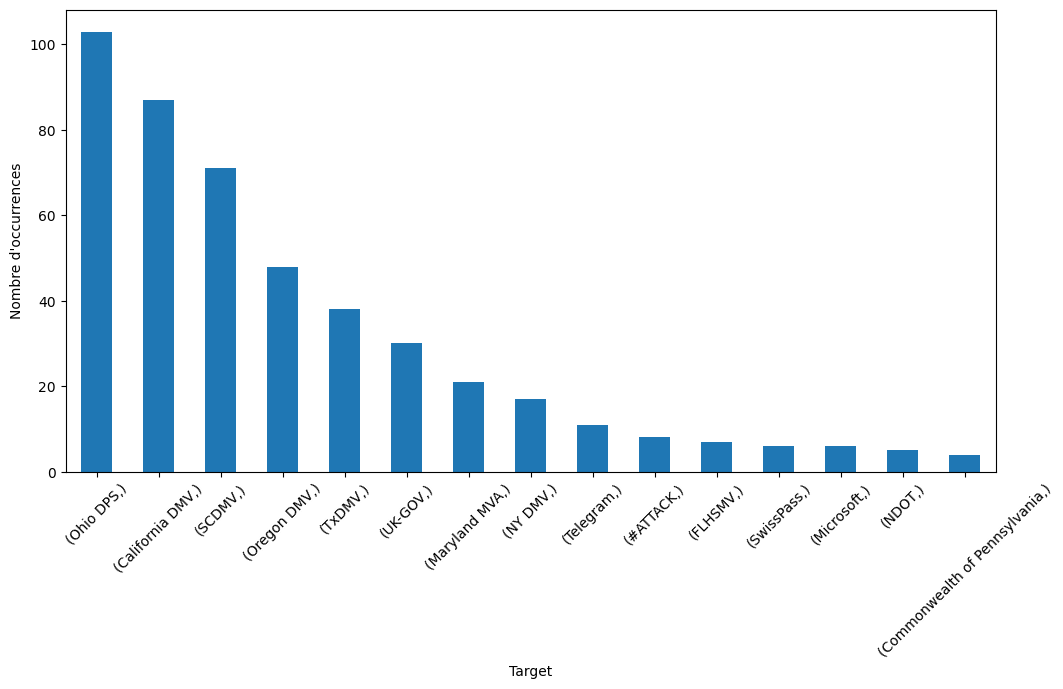

In [14]:
df[['target']].value_counts().head(15).plot.bar(figsize=(12, 6), xlabel='Target', ylabel='Nombre d\'occurrences', rot=45)

In [15]:
# Liste des valeurs à rechercher
targets = [
    'Ohio DPS', 'California DMV', 'SCDMV', 'Oregon DMV', 'TxDMV', 'UK-GOV',
    'Maryland MVA', 'NY DMV', 'Telegram', '#ATTACK', 'FLHSMV', 'SwissPass',
    'Microsoft', 'NDOT'
]

# Boucle pour afficher les 10 premières lignes de chaque valeur de 'target'
for target in targets:
    print(f"Top 10 pour {target}:")
    print(df[df['target'].str.contains(target, case=False, na=False)].head(10))
    print("\n" + "-"*50 + "\n")

Top 10 pour Ohio DPS:
       target                         url
112  Ohio DPS  http://gov-tollbillrsg.bid
113  Ohio DPS  http://gov-tollbillrsf.bid
114  Ohio DPS  http://gov-tollbillrsh.bid
115  Ohio DPS  http://gov-tollbillrsi.bid
117  Ohio DPS  http://gov-tollbillrsb.bid
118  Ohio DPS  http://gov-tollbillrsj.bid
119  Ohio DPS  http://gov-tollbillrsk.bid
120  Ohio DPS  http://gov-tollbillrsl.bid
121  Ohio DPS  http://gov-tollbillrsm.bid
122  Ohio DPS  http://gov-tollbillrsn.bid

--------------------------------------------------

Top 10 pour California DMV:
             target                    url
322  California DMV  http://gov-payvfk.icu
323  California DMV  http://gov-payvnw.icu
324  California DMV  http://gov-paywdo.icu
325  California DMV  http://gov-paywhi.icu
326  California DMV  http://gov-paywin.icu
327  California DMV  http://gov-paywmj.icu
328  California DMV  http://gov-paywml.icu
329  California DMV  http://gov-paywnh.icu
330  California DMV  http://gov-paywpa.icu
331  